## Семинар 1 "Полносвязные нейронные сети"

ФИО: Дегтярев Роман Олегович

В этом задании вам предстоит реализовать проход "вперед" для полносвязной нейронную сети. В дальнейшем мы реализуем процедуру обучения и научим сеть распознавать рукописные цифры.

На первой лекции мы познакомились с тем, что такое нейронные сети и изучили три слоя — линейный, сигмоида и SoftMax. Из этих слоев можно составлять глубокие архитектуры и обучать их при помощи градиентного спуска. Чтобы конструировать сложные архитектуры, можно реализовать каждый тип слоя как отдельный "кирпичик" и затем собирать полную архитектуру как конструктор. Это мы и попробуем сделать на первом и втором семинарах.

Каждый тип слоя мы будем реализовывать при помощи класса, который будет поддерживать три функции: forward, которая будет применять функцию, реализуемую слоем, к входной матрице и backward, которая будет вычислять градиенты и step, которая будет обновлять веса. Чтобы не применять функцию к каждому объекту в отдельности, мы будем подавать на вход слою матрицу размера (N, d), где N — количество объектов, а d — размерность каждого объекта.

<img src=backprop.pdf width=400>

Функция forward будет вычислять по $x$ значение $y$, backward — по $\frac{\partial L}{\partial y}$ вычислять $\frac{\partial L}{\partial x}$ и обновлять внутри себя $\frac{\partial L}{\partial w}$.

Важным требованием к реализации является векторизация всех слоев: все операции должны быть сведены к матричным, не должно быть циклов. Это значительно уменьшает временные затраты.

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import re
%matplotlib inline

### Часть 1: Линейный слой


In [44]:
import numpy as np

class Linear:
    def __init__(self, input_size, output_size):        
        '''
        Creates weights and biases for linear layer.
        Dimention of inputs is *input_size*, of output: *output_size*.
        '''
        #### YOUR CODE HERE
        #### Create weights, initialize them with samples from N(0, 0.1).
        
        self.w = np.random.normal(0,0.1, (input_size+1, output_size))
        
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, input_size)
        '''
        #### YOUR CODE HERE
        #### Apply layer to input
        self.X = np.append(X, np.ones((X.shape[0],1)), axis=1)
        
        self.y = np.dot(self.X, self.w)
        return self.y
    
    def backward(self, dLdy):
        '''
        dLdy [N, output_size]
        '''
        '''
        1. Compute dLdw and dLdx.
        2. Store dLdw for step() call
        3. Return dLdx
        '''
        #### YOUR CODE HERE
        self.dLdw = np.dot(self.X.T, dLdy)
        self.dLdx = np.dot(dLdy, self.w.T)

        return self.dLdx[:,:(self.X.shape[1]-1)]
    
    def step(self, learning_rate):
        '''
        1. Apply gradient dLdw to network:
        w <- w - l*dLdw
        '''
        #### YOUR CODE HERE
        
        self.w = self.w - learning_rate * self.dLdw
        
        

### Часть 2: Сигмоида

In [45]:
class Sigmoid:
    def __init__(self):
        
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        #### YOUR CODE HERE
        self.X = np.array(X)
        self.sig = 1 / (1 + np.exp(-self.X))
        return self.sig
        
       
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        #### YOUR CODE HERE
       
        return dLdy * self.sig * (1 - self.sig)
    
    def step(self, learning_rate):
        pass

### Часть 3: Функция потерь

Как мы увидели на семинаре, вычисление производной для связки SoftMax + Negative log-likelihood проще чем для этих двух слоев по отдельности. Поэтому мы реализуем их как один класс. Важное замечание: на проходе "вперед" важно воспользоваться трюком <a href="https://hips.seas.harvard.edu/blog/2013/01/09/computing-log-sum-exp/">log-sum-exp</a>, чтобы не столкнуться с численными неустойчивостями.

In [46]:
class NLLLoss:
    def __init__(self):
        '''
        Applies Softmax operation to inputs and computes NLL loss
        '''
        #### YOUR CODE HERE
        #### (Hint: No code is expected here, just joking)
        pass
    
    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        y is np.array of size (N,), contains correct labels
        '''
        #### YOUR CODE HERE
        #### Apply layer to input
        self.X = X
        Xmax = np.max(X,axis=1) # keep axis 0 (different points) intact
        self.L = X[range(X.shape[0]),y] - Xmax - np.log( # trigger NumPy's "smart indexing" by feeding both array-like
            np.sum( # log-sum-exp to avoid floating overflows
                np.exp(
                    (X.T-Xmax).T # hooray for NumPy broadcasting
                ),
                axis=1
            )
        )
        
        return -self.L
        
          
    def backward(self):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        #### YOUR CODE HERE
        local_max = np.max(self.X,axis=1)
        self.dLdx = -np.exp(
            self.X.T - local_max - np.log(
                np.sum(
                    np.exp(self.X.T-local_max),
                    axis=0
                )
            )
        ).T
        self.dLdx[range(X.shape[0]),y] += 1
        self.dLdx = -self.dLdx # *negative*
        
        return self.dLdx

In [47]:
class NeuralNetwork:
    def __init__(self, modules):
        '''
        Constructs network with *modules* as its layers
        '''
        #### YOUR CODE HERE

        self.list = []
        for m in modules:
            self.list.append(m)
    
    def forward(self, X):
        #### YOUR CODE HERE
        #### Apply layers to input
        XX = np.array(X)
        for i in self.list:
            XX = i.forward(XX)
        return XX
    
    def backward(self, dLdy):
        '''
        dLdy here is a gradient from loss function
        '''
        #### YOUR CODE HERE
        QQ = dLdy
        for i in self.list[::-1]:
            QQ = i.backward(QQ)
        return QQ
    
    def step(self, learning_rate):
        for l in self.list:
            l.step(learning_rate)

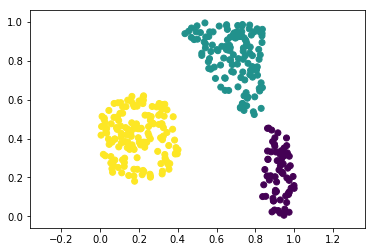

In [48]:
data = np.load('data.npz')
X, y = data['arr_0'], data['arr_1']


plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis('equal')
plt.show()

In [49]:
### YOUR CODE HERE:
lr = 0.01
terminator = NeuralNetwork([Linear(2,10), Sigmoid(), Linear(10,10), Sigmoid(), Linear(10,3)])
loss = NLLLoss()
losts = []
for i in range(1000):
    losts.append(loss.forward(terminator.forward(X), y))
    terminator.backward(loss.backward())
    terminator.step(lr)

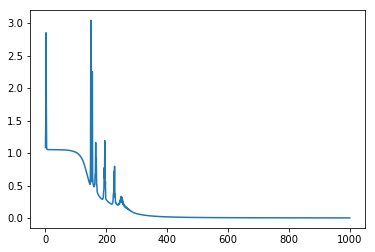

In [50]:
losts = np.array(losts)
plt.plot(losts.mean(axis=1))

plt.show()

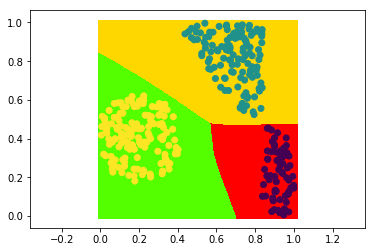

In [51]:
points = 500
xx = np.linspace(min(X[:,0]),max(X[:,0]),points)
yy = np.linspace(min(X[:,1]),max(X[:,1]),points)

xc, yc = np.meshgrid(xx,yy)

Xgrid=np.array((xc.ravel(), yc.ravel())).T
plt.scatter(xc,yc,c=terminator.forward(Xgrid).argmax(axis=1),marker=",",cmap="prism")
plt.scatter(X[:,0],X[:,1],c=y)
plt.axis('equal')
plt.show()

In [52]:
# the only gradient we can check is NLL loss function by a single input weight
w = terminator.forward(X) # let's get a reasonable weight value
eps = np.zeros(w.shape[1])


eps[0] = 1e-6

loss.forward(w,y) 
grad_1 = loss.backward()[:,0]

# then estimate it numerically from L
grad_num = (loss.forward(w+eps,y)-loss.forward(w-eps,y))/(2*eps[0])
print "Numerical gradient =", np.sqrt(np.mean(((grad_1-grad_num)**2)))

Numerical gradient = 4.9462688056e-11
